In [1]:
#dependencies
from scipy.optimize import linprog, minimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
all_sheets = pd.read_excel('data/Portfolio_optimization_dataset.xlsx', sheet_name=None)

stocksPrices = all_sheets["Prix"]
additionalStocksPrices = all_sheets["Compléments Prix Fininfo"]
portfolios = all_sheets["Positions ptf"]
portfoliosPerformance = all_sheets["Performances"]

In [3]:
portfolios_ids = portfolios['Portefeuille'].unique()
print(f"Available portfolios: {portfolios_ids}")

Available portfolios: ['45850000090000027072' '45850000090000081346' '45850000090000085342'
 '458500000900000703314' '458500000900000714518' '458500000900000717993'
 '458500000900000718002' '458500000900000718004' '458500000900000719643'
 '458500000900000723794' '458500000900000744940' '458500000900000745965']


In [4]:
def returns_per_universe(stocksPrices, portfolios, portfolio_id, start_date, end_date):
    """
    Calculate the daily return for each stock in a specific portfolio_id between start_date and end_date
    """
    
    pivoted_stocksPrices = (
        stocksPrices.pivot(index='Date', columns='Code ISIN', values='Cours')  # Pivot to wide format
    )
    universe_stocks = portfolios[portfolios['Portefeuille'] == portfolio_id]['ISIN']
    universe_stocksPrices = pivoted_stocksPrices[universe_stocks]
    filtred_stocksPrices = universe_stocksPrices[(universe_stocksPrices.index >= start_date) & (universe_stocksPrices.index <= end_date)]

    # Shift prices by 1 row to align with "previous day"
    prev_prices = filtred_stocksPrices.shift(1)
    # Avoid division by zero or NaN issues
    returns = ((filtred_stocksPrices - prev_prices) / prev_prices) * 100
    returns[(prev_prices.isna()) | (prev_prices == 0)] = np.nan

    return returns

## Mean-Variance Optimization Model (Markovitz)

$$
\text{max} \left( \sum_{i=1}^{N} W_i \cdot \mu_i \right)
$$

$$
\text{min} \left( \sqrt{\sum_{i} \sum_{j} W_i \cdot W_j \cdot \sigma_{ij}} \right)
$$

Subject to:

$$
\sum_{i=1}^{N} W_i = 1
$$

$$
0 \leq W_i \leq 1
$$
where: 
- $W_i$ is the weight of stock i.
- $\sigma_{ij}$ is the covariance between return of stock i and stock j.
- $\mu_i$ is the mean of return stoch i.


### Obtaining the Maximal Expected Return of the Portfolio

$$
\text{max} \left( \sum_{i=1}^{N} W_i \cdot \mu_i \right)
$$
Subject to:

$$
\sum_{i=1}^{N} W_i = 1
$$

$$
0 \leq W_i \leq 1
$$


In [5]:
def MaximizeReturns(MeanReturns):
    
    c = (np.multiply(-1, MeanReturns))
    A = np.ones([len(MeanReturns), 1]).T
    b = [1]
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1)) 
    
    return res

### Obtaining the Optimal Expected Return of a Minimum Risk Portfolio

$$
\text{min} \left( \sqrt{\sum_{i} \sum_{j} W_i \cdot W_j \cdot \sigma_{ij}} \right) <=> \text{min} \left( W^T~\Sigma ~W\right)
$$

Subject to:

$$
\sum_{i=1}^{N} W_i = 1
$$

$$
0 \leq W_i \leq 1
$$


In [6]:
def MinimizeRisk(CovarReturns):
    
    def  f(x, CovarReturns):
        func = np.matmul(np.matmul(x, CovarReturns), x.T) 
        return func

    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    xinit=np.repeat(0.1, CovarReturns.shape[0])
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
    return opt

### Obtaining the Optimal Weights for Minimum Risk and Maximum Return Portfolios

$$
\text{min} \left( \sqrt{\sum_{i} \sum_{j} W_i \cdot W_j \cdot \sigma_{ij}} \right) <=> \text{min} \left( W^T~\Sigma ~W\right)
$$

Subject to:

$$
\left( \sum_{i=1}^{N} W_i \cdot \mu_i \right) \leq R
$$

$$
\sum_{i=1}^{N} W_i = 1
$$

$$
0 \leq W_i \leq 1
$$


In [7]:
def MinimizeRiskConstr(MeanReturns, CovarReturns, R):
    
    def  f(x,CovarReturns):
         
        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal
    

    xinit = np.ones(len(MeanReturns)) / len(MeanReturns)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = minimize (f, args = (CovarReturns), \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-5)
    
    return  opt

### Case Study

In [8]:
start_date = pd.to_datetime("2024-02-11")
end_date = pd.to_datetime("2024-08-11")
portfolio_id1 = '45850000090000027072'

returns_univ1 = returns_per_universe(stocksPrices, portfolios, portfolio_id1, start_date, end_date)

meanReturnsUniv1 = np.nanmean(returns_univ1, axis=0)
covReturnsUniv1 = returns_univ1.cov().to_numpy()


In [9]:
#Maximal expected portfolio return computation for the k-portfolio
result1 = MaximizeReturns(meanReturnsUniv1)
maxReturnWeights = result1.x
maxExpPortfolioReturn = np.matmul(meanReturnsUniv1.T, maxReturnWeights)
print("Selected weights: ",maxReturnWeights)
print("Maximal Expected Portfolio Return:   %7.4f" % maxExpPortfolioReturn )

Selected weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Maximal Expected Portfolio Return:    0.3431


In [10]:
#expected portfolio return computation for the minimum risk k-portfolio 
result2 = MinimizeRisk(covReturnsUniv1)
minRiskWeights = result2.x
minRiskExpPortfolioReturn = np.matmul(meanReturnsUniv1.T, minRiskWeights)
print("Selected weights: ",minRiskWeights)
print("Expected Return of Minimum Risk Portfolio:  %7.4f" % minRiskExpPortfolioReturn)

Selected weights:  [1.45831072e-02 5.44579994e-02 5.74121592e-02 6.89165017e-02
 4.68239813e-17 1.99018861e-17 1.20872192e-02 6.50521303e-19
 1.56125113e-17 0.00000000e+00 1.07133334e-01 6.72619591e-01
 1.12350450e-17 1.27900881e-02 5.19265078e-17 0.00000000e+00
 0.00000000e+00]
Expected Return of Minimum Risk Portfolio:  -0.0129


In [11]:
def EfficientFrontierMarkovitz(meanReturnsUniv, covReturnsUniv, low, high):
    #compute efficient set for the maximum return and minimum risk portfolios
    increment = 0.001

    #initialize optimal weight set and risk-return point set
    xOptimal =[]
    minRiskPoint = []
    expPortfolioReturnPoint =[]

    #repeated execution of function MinimizeRiskConstr to determine the efficient set 
    while (low < high):
        
        result3 = MinimizeRiskConstr(meanReturnsUniv, covReturnsUniv, low)
        xOptimal.append(result3.x)
        expPortfolioReturnPoint.append(low)
        low = low+increment
        
    #gather optimal weight set    
    xOptimalArray = np.array(xOptimal)

    #obtain annualized risk for the efficient set portfolios 
    #for trading days = 251
    minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray,covReturnsUniv)),\
                                        np.transpose(xOptimalArray)))
    riskPoint =   np.sqrt(minRiskPoint*251) 

    #obtain expected portfolio annualized return for the 
    #efficient set portfolios, for trading days = 251
    retPoint = 251*np.array(expPortfolioReturnPoint) 

    #plot expected return per risk 
    colours = "blue"
    area = np.pi*3

    plt.title('Efficient Frontier ')
    plt.xlabel('Annualized Risk(%)')
    plt.ylabel('Annualized Expected Portfolio Return(%)' )
    plt.scatter(riskPoint, retPoint, s=area, c=colours, alpha =0.5)
    plt.show()

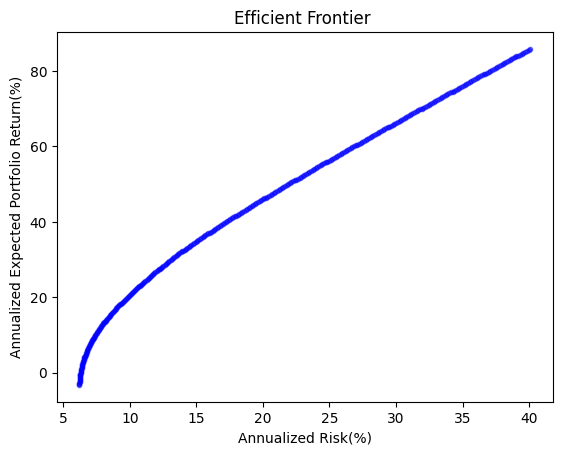

In [12]:
EfficientFrontierMarkovitz(meanReturnsUniv1, covReturnsUniv1, minRiskExpPortfolioReturn, maxExpPortfolioReturn)


In [29]:
def apply_markovitz(stocksPrices, portfolios, portfolio_id, start_date_calib, end_date_calib, expected_return, plot_future_perf=True):

    calib_returns = returns_per_universe(stocksPrices, portfolios, portfolio_id, start_date_calib, end_date_calib)
    meanReturns = np.nanmean(calib_returns, axis=0)
    covReturns = calib_returns.cov().to_numpy()

    result = MinimizeRiskConstr(meanReturns, covReturns, expected_return)
    print("Portfolio weights: ")
    weights_df = pd.DataFrame([result.x], columns=calib_returns.columns)
    pd.set_option('display.max_columns', None)
    print(weights_df)

    if plot_future_perf:
        start_date_test = pd.to_datetime("2024-08-12")
        end_date_test = pd.to_datetime("2024-10-09")
        future_returns = returns_per_universe(stocksPrices, portfolios, portfolio_id, start_date_test, end_date_test)
        future_returns['Weighted_Return'] = future_returns.dot(result.x)
        future_returns['Cumulative_Return'] = future_returns['Weighted_Return'].cumsum()
        RealPerformance = portfoliosPerformance[portfoliosPerformance['Portefeuille']==portfolio_id]
        
        plt.figure(figsize=(10,6))
        plt.plot(future_returns.index, future_returns['Cumulative_Return'], label="Markovitz")
        plt.plot(RealPerformance['HPA_Dat'], RealPerformance['Performance (%)'], label="actual performance")
        plt.title(f"Performance of portfolio {portfolio_id}")
        plt.legend()
        plt.show()


Portfolio weights: 
Code ISIN  FR0000051070  FR0000052292  FR0000073272  FR0000120321  \
0          7.334173e-15  1.362179e-14      0.129108           0.0   

Code ISIN  FR0000121014  FR0000121147  FR0000125338  FR0000125486  \
0          2.715143e-15  3.227871e-14  2.736696e-15  3.710048e-15   

Code ISIN  FR0000130452  FR0000130809  FR0000133308  FR0000435505  \
0          6.976234e-15  1.630976e-14           0.0           0.0   

Code ISIN  FR0000990095  FR0010220475  FR0010574434  FR0010632364  \
0                   0.0      0.523616           0.0      0.347276   

Code ISIN  FR0013254380  
0                   0.0  


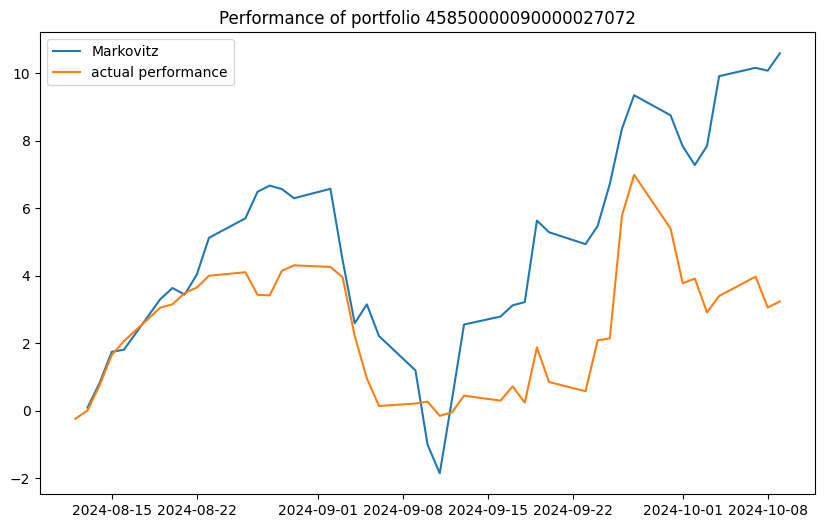

In [30]:
apply_markovitz(stocksPrices, portfolios, portfolio_id1, start_date, end_date, 0.2, plot_future_perf=True)

Portfolio weights: 
Code ISIN  FR0000051807  FR0000053324  FR0000054470  FR0000130809  \
0          3.467775e-12  3.498023e-17  1.259638e-12  1.026039e-12   

Code ISIN  FR0004180578  FR0010112524  FR0010282822  FR0010411983  \
0          1.872692e-17  9.121001e-12  9.330148e-14  1.344590e-12   

Code ISIN  FR0011636158  FR0011981968  FR0012613610  FR0013006558  \
0          8.947504e-17  2.469884e-12  1.634516e-12  5.434295e-17   

Code ISIN  FR0013258662  FR0013379484  FR0013451333  FR0014003TT8  \
0                   1.0  5.497507e-12  3.928563e-17  3.066381e-18   

Code ISIN  FR00140043Y1  FR001400J770  IT0005366767  NL0014559478  \
0          7.488113e-17  2.334825e-18  1.166671e-18  2.450361e-17   

Code ISIN  NL0015001W49  
0          2.142995e-17  


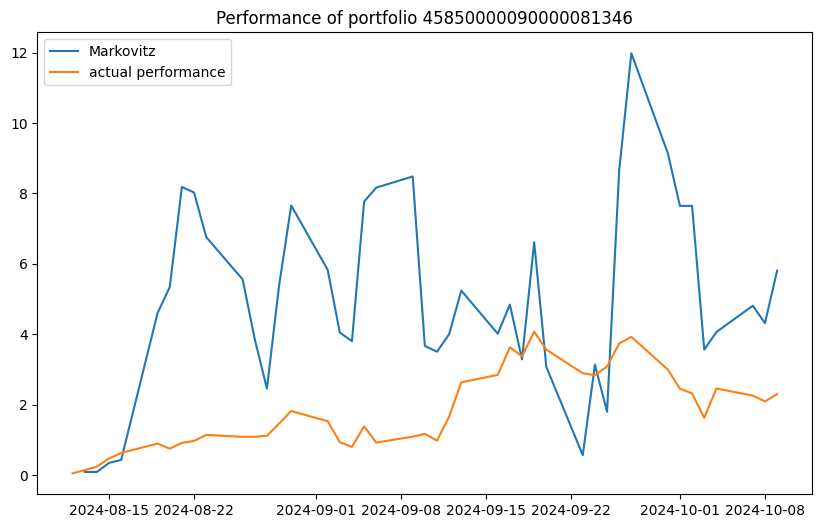

In [31]:
apply_markovitz(stocksPrices, portfolios, "45850000090000081346", start_date, end_date, 0.2, plot_future_perf=True)

Portfolio weights: 
Code ISIN  FR0000052292  FR0000053951  FR0000073272  FR0000120073  \
0          1.800819e-18  9.697956e-12           1.0  5.489557e-19   

Code ISIN  FR0000120321  FR0000121014  FR0000121667  FR0000124141  \
0          2.912573e-13  1.872295e-13  1.695847e-11  8.118767e-16   

Code ISIN  FR0011871110  FR0013154002  FR0014003TT8  NL0000334118  
0          8.905008e-17  6.447123e-18  1.417075e-15  2.849853e-12  


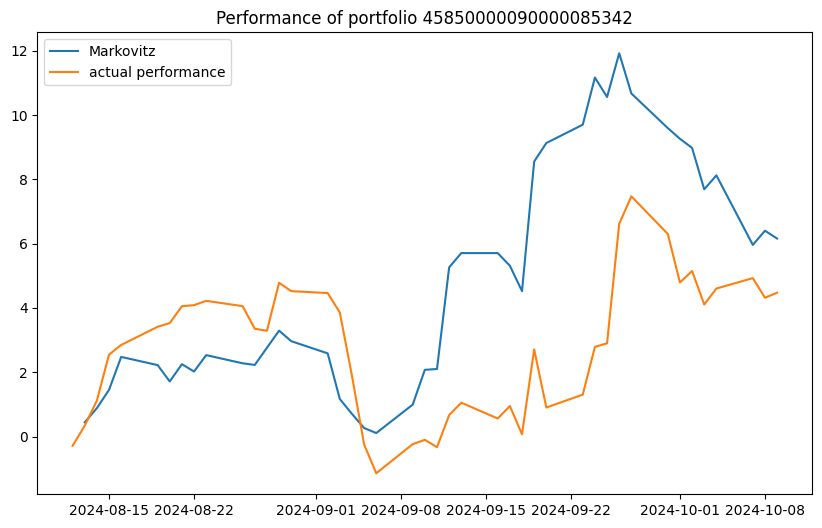

In [32]:
apply_markovitz(stocksPrices, portfolios, "45850000090000085342", start_date, end_date, 0.2, plot_future_perf=True)

Portfolio weights: 
Code ISIN  FR0000051807  FR0000054470  FR0000130809  FR0004180578  \
0                   0.0  1.674440e-14           0.0  8.976110e-15   

Code ISIN  FR0010282822  FR0010411983  FR0011636158  FR0011981968  \
0          2.880897e-16  8.133527e-15       0.65839           0.0   

Code ISIN  FR0012613610  FR0013006558  FR0013258662  FR0013379484  \
0          3.189049e-15  1.593163e-14      0.285534           0.0   

Code ISIN  FR0013451333  FR0014003TT8  FR00140043Y1  FR001400J770  \
0          1.638776e-14  1.232673e-14      0.056076  7.038071e-16   

Code ISIN  NL0015001W49  
0          4.574631e-15  


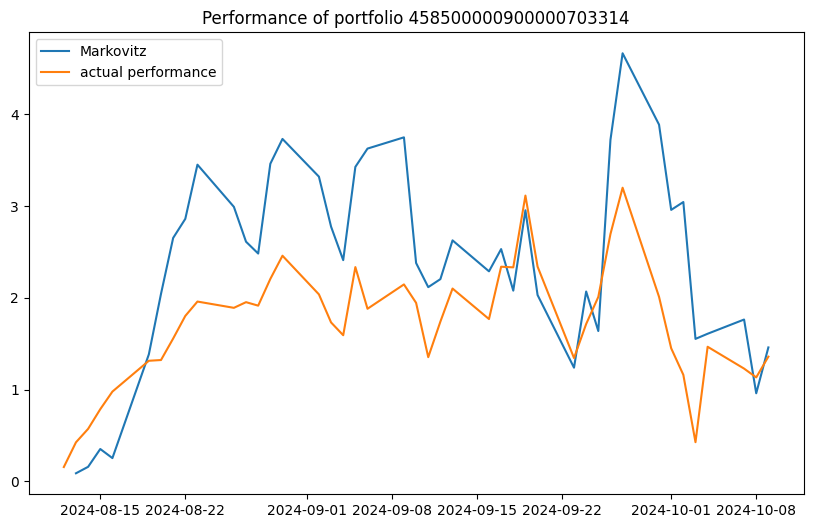

In [33]:
apply_markovitz(stocksPrices, portfolios, "458500000900000703314", start_date, end_date, 0.05, plot_future_perf=True)

Portfolio weights: 
Code ISIN  FR0000052292  FR0000053951  FR0000120321  FR0000121014  \
0          3.956802e-19           0.0  9.158387e-19  2.780126e-18   

Code ISIN  FR0010259150  FR0010313833  FR0010331421  FR0013447729  \
0                   1.0  1.356137e-13  1.346977e-13  3.088753e-12   

Code ISIN  FR0014000MR3  FR0014003TT8  NL0000235190  
0          1.261496e-13  2.393199e-18  1.130463e-18  


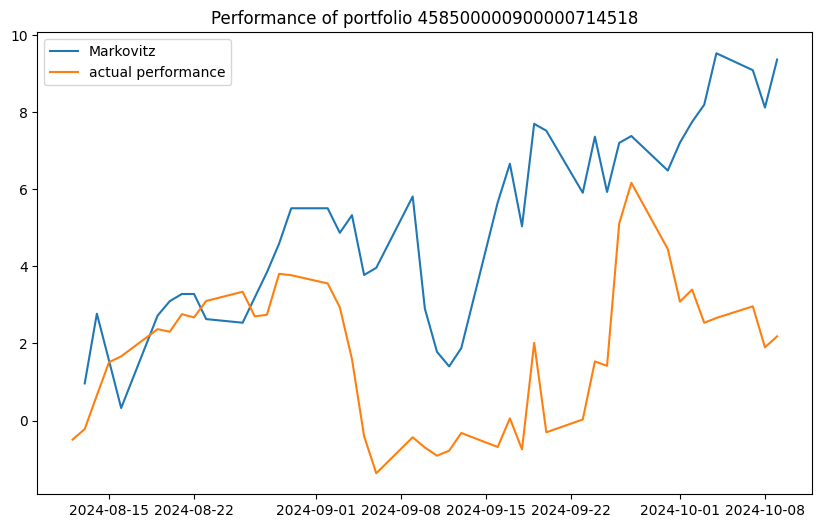

In [34]:
apply_markovitz(stocksPrices, portfolios, "458500000900000714518", start_date, end_date, 0.2, plot_future_perf=True)

Portfolio weights: 
Code ISIN  DE0009770206  ES0118594417  ES0171996087  FR0000039620  \
0              0.104129  4.744144e-15  2.845818e-15  3.530981e-15   

Code ISIN  FR0000120404  FR0000121147  FR0000124141  FR0006174348  \
0          6.306897e-15  1.090780e-14  5.286783e-15      0.188245   

Code ISIN  FR0010220475  FR0010533075  FR0011981968  FR0013426004  \
0              0.404006  8.739523e-15  8.403436e-15  3.515902e-15   

Code ISIN  FR0013506730  FR0014003TT8  FR0014008VX5  IT0003497168  \
0          6.494271e-15  8.406112e-15  9.825180e-15  5.825057e-15   

Code ISIN  NL0012817175  US0378331005  US92826C8394  
0          6.961882e-15      0.303619  1.003751e-14  


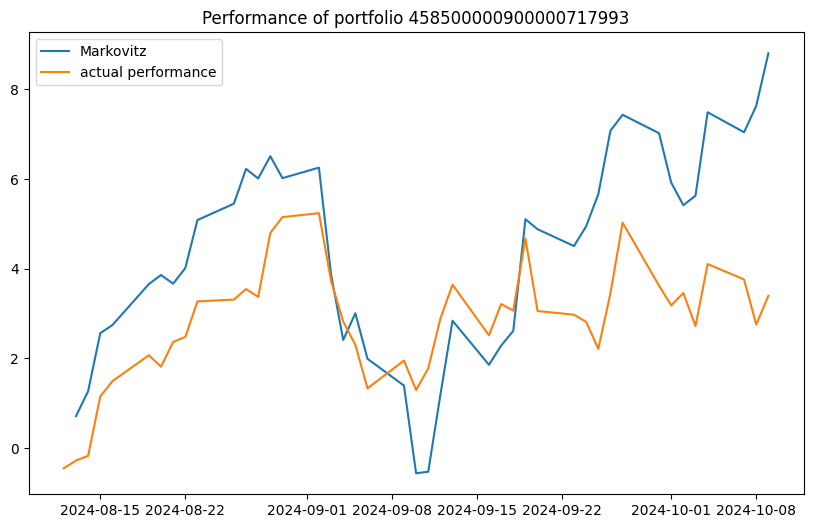

In [35]:
apply_markovitz(stocksPrices, portfolios, "458500000900000717993", start_date, end_date, 0.2, plot_future_perf=True)

Portfeuilles identiques:
- 458500000900000718004
- 458500000900000718002
- 458500000900000717993